# Motivation

The purpose of this notebook is to showcase my knowledge on covolutional neural networks applied to image classification and (possibly) object location. 

## Data

- SAR (Synthetics Apperture Radar) satellite data/images of the surface of Venus. The dataset aimes to classify pictures which have volcanoes in them how many there are and where they are in the image. 
- 1 channel.
- 110x110 array of pixels with values between 0 and 255.
- 7000 instances.
- Labels given:
    - Volcano: 1 or 0.
    - Type: 1 = definitely a volcano, 2 = probably, 3 = possibly, 4 = only a pit is visible.
    - Radius: in pixels.
    - Number Volcanoes: number of volcanoes in the image.
    
## Approach

- The images have around 12000 pixels in them so a dense NN would lose a lot of information if say it had 1000 neurons in the first layer. 
- Instead, I am going to try some small CNN architectures initially just trying to identify volcanoes and then onto more challenging tasks like the number of volcanoes!

## Skills showcased

In this notebook I will show:

- Training a convolutional neural network (CNN) to classify images. 
- Augmenting and preprocessing images before passing to the CNN. 
- Using custom metrics in keras.
- Saving a keras model with custom metrics.
- Load a pretrained model and reuse the layer's weights. 
- Have a CNN trained to return both a classification and additional information (here, number of volcanoes). 

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split



Bad key "text.kerning_factor" on line 4 in
/Users/jamieward/.matplotlib/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "mathtext.fallback" on line 156 in
/Users/jamieward/.matplotlib/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "axes.titley" on line 177 in
/Users/jamieward/.matplotlib/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# read in training data (can be found here: https://www.kaggle.com/code/behcetsenturk/finding-volcanoes-with-cnn/data)

train_data = pd.read_csv('./train_images.csv', header=None, index_col=False)
train_labels = pd.read_csv('./train_labels.csv', index_col=False)

# read in test data
test_data = pd.read_csv('./test_images.csv', header=None, index_col=False)
test_labels = pd.read_csv('./test_labels.csv', index_col=False)

# scale the data (values in the image are between 0 and 1)
train_data = train_data / 255.0


In [3]:
# define some parameters for the analysis 

batch_size=64
image_height = 110
image_width = 110
channels = 1

In [4]:
def remove_dodgy_images(array, number_constants):
    """
    Parameters
    ----------
    array : numpy 2D array of floats
        Array of values describing the image.

    number_constants : integer
        The number of values in the image to determine if it 
        is corrupt.

    Returns
    -------
    corrupt : bool
        if True, the array is corrupt and needs to be removed.
    
    """
    
    corrupt = False

    if np.sum(array[:number_constants]) == 0:
        corrupt = True
    else:
        pass

    # sum every 110th pixel
    pixel_sum = 0
    for i in range(0,len(array),110):
        pixel_sum += array[i]
        if i == number_constants:
            break
    if pixel_sum == 0:
        corrupt = True

        
    return corrupt
  
        
# train_df_filtered = pd.DataFrame(data=fine_data, columns = train_data.keys())
# corrupt_data = pd.DataFrame(data=corrupt_data, columns = train_data.keys())

In [5]:
# store indices in lists
corrupt_data_index = []
fine_data_index = []

# create empty dataframe to store corrupt images.
corrupt_data = pd.DataFrame()

# iterate though the training data, test if it is corrupt
# and store its index in the appropriate list. 
for i, row in train_data.iterrows():
    
    corrupt = remove_dodgy_images(row.values, number_constants=10)
    if corrupt == True:
        corrupt_data_index.append(i)
    if corrupt == False:
        fine_data_index.append(i)

In [6]:
# separate the corrupt and fine images
train_data_filt = train_data.iloc[fine_data_index]
train_labels_filt = train_labels.iloc[fine_data_index]
corrupt_data_filt = train_data.iloc[corrupt_data_index]
corrupt_labels_filt = train_labels.iloc[corrupt_data_index]

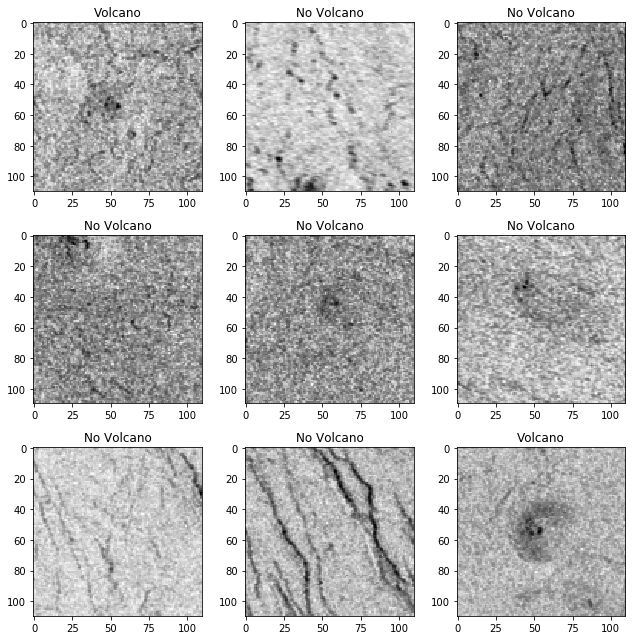

In [7]:

def show_images(data, labels, rows, columns):
    n_images = rows * columns
    fig, axs = plt.subplots(rows,columns, figsize=(9, 9))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        row = data.iloc[i]
        label = labels.iloc[i]
        ax.imshow(np.array(row).reshape((110,110)), cmap='Greys')
        volcano = label['Volcano?']
        if volcano == 1.0:
            title = 'Volcano'
        else:
            title = 'No Volcano'
        ax.set_title(title)
    plt.tight_layout()
    plt.show()
    return    
        
show_images(data=train_data_filt, labels=train_labels_filt, rows=3, columns=3)

In [8]:
# out of interest, just see how a dense NN would perform

# split into train and valid set
valid_percentage = 0.2

# the data and labels are automatically shuffled with this function. 
train_data, valid_data, train_labels, valid_labels = train_test_split(train_data_filt, 
                                                                      train_labels_filt)

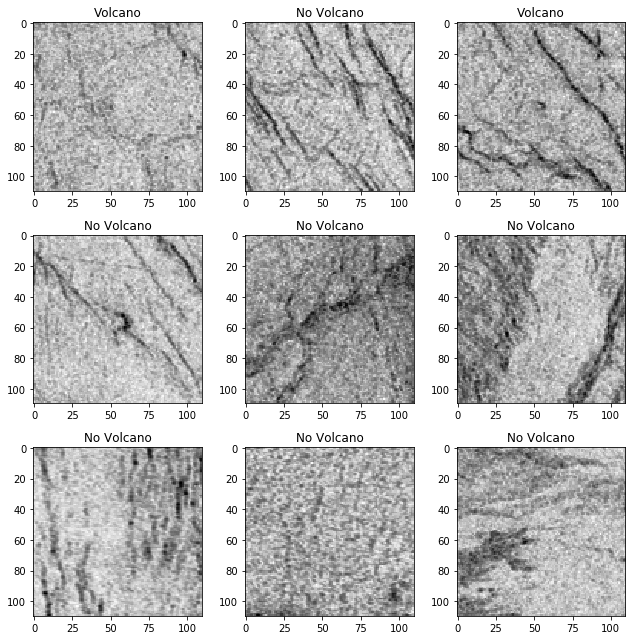

In [9]:
show_images(data=valid_data, labels=valid_labels, rows = 3, columns = 3)

In [10]:
train_data_test = train_data.values.reshape(len(train_data),110,110,1)
valid_data_test = valid_data.values.reshape(len(valid_data),110,110,1)
test_data_test = test_data.values.reshape(len(test_data),110,110,1)


In [13]:
# Augment data using own function for flipping etc


def preprocess(image):
    import random
    # get random true false for vertical or horizontal flip
    vertical_q = bool(random.getrandbits(1))
    
    if vertical_q == True:
        aug_image = tf.image.random_flip_up_down(image)
    elif vertical_q == False:
        aug_image = tf.image.random_flip_left_right(image)
    else:
        aug_image = image 
    
    aug_image = tf.image.random_contrast(aug_image, 0.2, 0.5)    
    
    return aug_image

train_data_extended = np.repeat(train_data_test, 3, axis=0)

# get shuffled indices
shuffle_indices = np.random.permutation(train_data_extended.shape[0])

train_data_extended = train_data_extended[shuffle_indices]
# n_volc_train_augmented = n_volc_train_augmented[shuffle_indices]
train_data_augmented = np.empty(train_data_extended.shape)
train_data_augmented = map(preprocess, train_data_extended)

# for i,image in enumerate(train_data_extended):
#     train_data_augmented[i] = preprocess(image)

In [ ]:
# first just train on whether there is a volcano or not

train_labels_volcano_present =  train_labels['Volcano?'].values.reshape(-1, 1)
valid_labels_volcano_present =  valid_labels['Volcano?'].values.reshape(-1, 1)
test_labels_volcano_present =  test_labels['Volcano?'].values.reshape(-1, 1)

onehot = OneHotEncoder(sparse=False)
onehot.fit(train_labels_volcano_present)


In [ ]:
print(onehot.categories_)

train_labels_volcano_present = onehot.transform(train_labels_volcano_present)
valid_labels_volcano_present = onehot.transform(valid_labels_volcano_present)
test_labels_volcano_present = onehot.transform(test_labels_volcano_present)

In [ ]:
train_labels_v_present_augmented = np.repeat(train_labels_volcano_present, 3, axis=0)
train_labels_v_present_augmented = train_labels_v_present_augmented[shuffle_indices]


## Attempt 1

- Convolutional NN with a mix of conv and max pooling layers with ReLU activation function and a dense NN at the end with a softmax activation function. 
- There are multiple convolutional layers between each max pooling. In theory the second layer should be able to extract more complex patterns using the simple patterns picked up by the previous convolutional layer. 
- Dropout is used in the dense NN to avoid overfitting. This is where random neurons are turned off during training to ensure the output is not reliant on a select few neurons. 
- I will augment the data once I am happy the model is running properly. 

In [ ]:


model = keras.models.Sequential([
    keras.layers.Conv2D(filters=8, kernel_size=7, input_shape=[110, 110, 1],
                  activation='relu', padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=8,kernel_size=3, activation='relu', 
                  padding="SAME"),
    keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', 
                  padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', 
                  padding="SAME"),
    keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', 
                  padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=2, activation='softmax'),
])

In [ ]:
model.summary()


In [ ]:
# metrics for precision and recall seem to have some bugs so need to define our own metrics here

# honestly just taken from a github forum but commented
# so i know whats going on
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


In [ ]:

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', recall, precision])


In [ ]:
# train the model!

# define steps per epoch
steps_per_epoch = int( np.ceil(train_data_augmented.shape[0] / batch_size) )

# uncomment this if you want to retrain the model
# history = model.fit(train_data_augmented, train_labels_v_present_augmented, 
#                     epochs=10, batch_size=64, steps_per_epoch=steps_per_epoch,
#                     validation_data=(valid_data_test, valid_labels_volcano_present))

# I have a pretrained model ready so you dont have to do this again


In [ ]:
## Great! Now save the model so you dont have to train it again...

# uncomment this if you want to save the model
# model.save("Classify_Volcano_Binary.h5")


model = keras.models.load_model("Classify_Volcano_Binary.h5", custom_objects={"recall":recall, "precision":precision})

In [ ]:
# plot loss, accuracy and validation acc/loss

# plt.style.use('fivethirtyeight')
# pd.DataFrame(history.history).plot(figsize=(8, 5)) 
# plt.grid(True)
# plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
# plt.xlabel('Epoch')
# plt.ylabel('Measurement parameter')
# plt.show()

In [ ]:
# evaluate the model against the test set

model.evaluate(test_data_test, test_labels_volcano_present)

## Training to identify the number of volcanoes too

- I am going to treat this as a classification task in a similar way to the above.
    
## How

- Unlike the simple sequential models which only allow one output layer, the function api will allow different putpit layers with their own losses etc. 
- Process the columns using one hot encoding again. 



In [ ]:
# make label files

train_labels['Number Volcanoes'] = train_labels['Number Volcanoes'].fillna(0)
valid_labels['Number Volcanoes'] = valid_labels['Number Volcanoes'].fillna(0)
test_labels['Number Volcanoes'] = test_labels['Number Volcanoes'].fillna(0)

## Ok, I'm going to try and treat this as a classification task

n_volc_train = train_labels['Number Volcanoes'].values.reshape(-1,1)
n_volc_valid = valid_labels['Number Volcanoes'].values.reshape(-1,1)
n_volc_test = test_labels['Number Volcanoes'].values.reshape(-1,1)


In [ ]:
n_volc_train_augmented = np.repeat(n_volc_train, 3, axis=0)


# get shuffled indices
n_volc_train_augmented = n_volc_train_augmented[shuffle_indices]

In [ ]:
# get an idea of the distribution of the values for 'number of volcanoes'

train_labels['Number Volcanoes'].plot(kind='hist')
valid_labels['Number Volcanoes'].plot(kind='hist')
plt.show()
test_labels['Number Volcanoes'].plot(kind='hist')

ohe = OneHotEncoder(sparse=False)
ohe.fit(n_volc_train)

In [ ]:
# encode the number of volcanoes classes

# print(ohe.categories_)

# n_volc_train = ohe.transform(n_volc_train)
# n_volc_valid = ohe.transform(n_volc_valid)
# n_volc_test = ohe.transform(n_volc_test)

# print(n_volc_train.shape)
# print(n_volc_valid.shape)

In [ ]:

# use the pretrained model which tried to classify if there was a volcano or not
model = keras.models.load_model("Classify_Volcano_Binary.h5", custom_objects={"recall":recall, "precision":precision})

base_model = model.layers[:-1]
print(base_model[-1].output)

for layer in base_model:
    layer.trainable = False
    
# create new output layers
class_out = model.layers[-1](base_model[-1].output)
reg_out = keras.layers.Dense(1)(base_model[-1].output)

# create new model
new_model = keras.Model(inputs = model.input,
                        outputs=[class_out, reg_out])

In [ ]:
new_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[0.5, 0.5],
                  optimizer='adam', metrics=["accuracy", "mse"])


In [ ]:
for layer in new_model.layers[:-2]:
    layer.trainable=False
    
new_model.compile(loss=["binary_crossentropy", "mse"], 
                  loss_weights=[0.5, 0.5],
                  optimizer='adam', metrics=["accuracy", "mse"])

In [ ]:
new_history = new_model.fit(train_data_augmented, [train_labels_v_present_augmented, n_volc_train_augmented],
                            epochs=10, batch_size=64, steps_per_epoch=steps_per_epoch,
                            validation_data=(valid_data_test, [valid_labels_volcano_present, n_volc_valid]))

In [ ]:
## Ok so using the old layers seems to work well (even on the valid dataset)
# unfreeze layers and train it more
for layer in new_model.layers[:-2]:
    layer.trainable=True
new_model.compile(loss=["binary_crossentropy", "mse"], 
                  loss_weights=[0.5, 0.5],
                  optimizer='adam', metrics=["accuracy", 'mse'])


In [ ]:
new_history = new_model.fit(train_data_test, [train_labels_volcano_present, n_volc_train],
                            epochs=10, batch_size=64, steps_per_epoch=steps_per_epoch,
                            validation_data=(valid_data_test, [valid_labels_volcano_present, n_volc_valid]))

In [ ]:
# ok save this model! 
new_model.save("Classify_Volcano_Number_Volcanoes.h5")

# new_model = keras.models.load_model("Classify_Volcano_Number_Volcanoes.h5")


In [ ]:
new_model.evaluate(test_data_test, [test_labels_volcano_present, n_volc_test])

## Thoughts

- Despite doing very well on the validation set, the model has performed ok on the test set. Unfortunately, the mse for identifying the number of volcanoes is massive! Clearly overtraining on the training set. Need to inspect the test set to see if it is similar or representative. 
- For now, I feel I have showcased I can train a CNN, augment/preprocess data, save a tf model, load a pretrained model and reuse the layers, create a neural network to both classify an image and return additional information about the image.